## Install
Поставим sahi + yolov5 в качестве детектора 

In [ ]:
!pip install -U torch sahi yolov5

In [ ]:
import os
os.getcwd()

## Import

In [108]:
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
from sahi.utils.yolov5 import (
    download_yolov5s6_model,
)

from sahi import AutoDetectionModel
from sahi.slicing import slice_image
from sahi.utils.cv import read_image
from sahi.utils.file import download_from_url
from sahi.predict import get_prediction, get_sliced_prediction, predict
from IPython.display import Image as display_image

## Download

In [ ]:
# download YOLOV5S6 model to 'models/yolov5s6.pt'
yolov5_model_path = 'models/yolov5s6.pt'
download_yolov5s6_model(destination_path=yolov5_model_path)

# download test images into demo_data folder
download_from_url('https://raw.githubusercontent.com/obss/sahi/main/demo/demo_data/small-vehicles1.jpeg',
                  'demo_data/small-vehicles1.jpeg')
download_from_url('https://raw.githubusercontent.com/obss/sahi/main/demo/demo_data/terrain2.png',
                  'demo_data/terrain2.png')

## Без SAHI

In [139]:
print(AutoDetectionModel.from_pretrained.__doc__)


        Loads a DetectionModel from given path.

        Args:
            model_type: str
                Name of the detection framework (example: "yolov5", "mmdet", "detectron2")
            model_path: str
                Path of the detection model (ex. 'model.pt')
            config_path: str
                Path of the config file (ex. 'mmdet/configs/cascade_rcnn_r50_fpn_1x.py')
            device: str
                Device, "cpu" or "cuda:0"
            mask_threshold: float
                Value to threshold mask pixels, should be between 0 and 1
            confidence_threshold: float
                All predictions with score < confidence_threshold will be discarded
            category_mapping: dict: str to str
                Mapping from category id (str) to category name (str) e.g. {"1": "pedestrian"}
            category_remapping: dict: str to int
                Remap category ids based on category names, after performing inference e.g. {"car": 3}
            load_a

In [ ]:
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov5',
    model_path=yolov5_model_path,
    confidence_threshold=0.3,
    device="cpu",  # or 'cuda:0'
)

get_prediction можно скармливать путь + AutoDetectionModel

In [11]:
result = get_prediction("demo_data/small-vehicles1.jpeg", detection_model)

или np.ndarray + AutoDetectionModel

In [144]:
print(read_image.__doc__)


    Loads image as numpy array from given path.
    


In [146]:
result = get_prediction(read_image(
    "demo_data/small-vehicles1.jpeg"), detection_model)

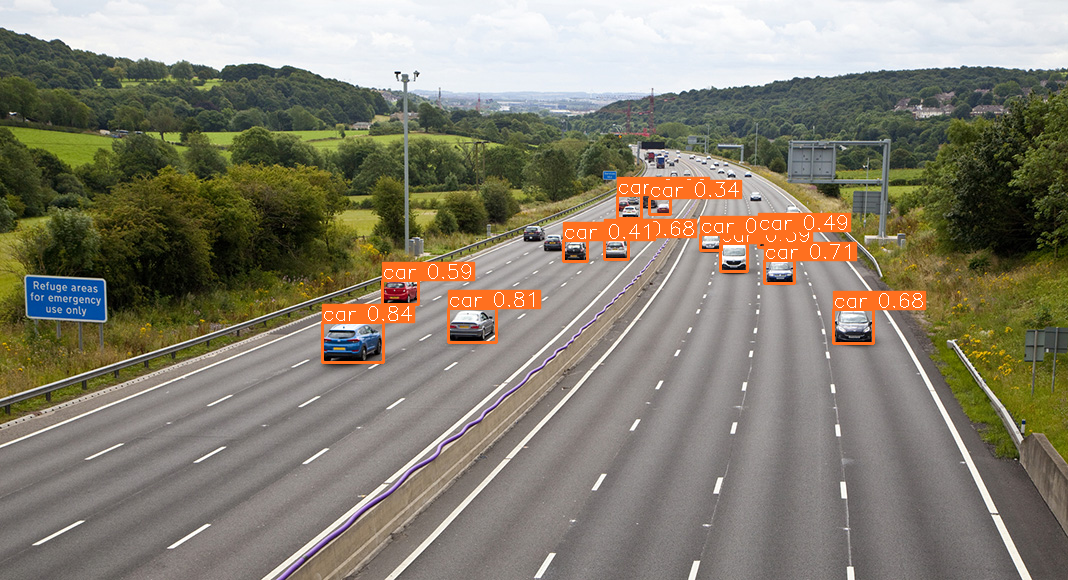

In [149]:
result.export_visuals(export_dir="demo_data/")

display_image("demo_data/prediction_visual.png")

## С SAHI

In [151]:
print(get_sliced_prediction.__doc__)


    Function for slice image + get predicion for each slice + combine predictions in full image.

    Args:
        image: str or np.ndarray
            Location of image or numpy image matrix to slice
        detection_model: model.DetectionModel
        slice_height: int
            Height of each slice.  Defaults to ``None``.
        slice_width: int
            Width of each slice.  Defaults to ``None``.
        overlap_height_ratio: float
            Fractional overlap in height of each window (e.g. an overlap of 0.2 for a window
            of size 512 yields an overlap of 102 pixels).
            Default to ``0.2``.
        overlap_width_ratio: float
            Fractional overlap in width of each window (e.g. an overlap of 0.2 for a window
            of size 512 yields an overlap of 102 pixels).
            Default to ``0.2``.
        perform_standard_pred: bool
            Perform a standard prediction on top of sliced predictions to increase large object
            detecti

In [152]:
# Прямо как в README
result = get_sliced_prediction(
    "demo_data/small-vehicles1.jpeg",
    detection_model,
    slice_height=256,
    slice_width=256,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
    verbose=0
)

другое дело:

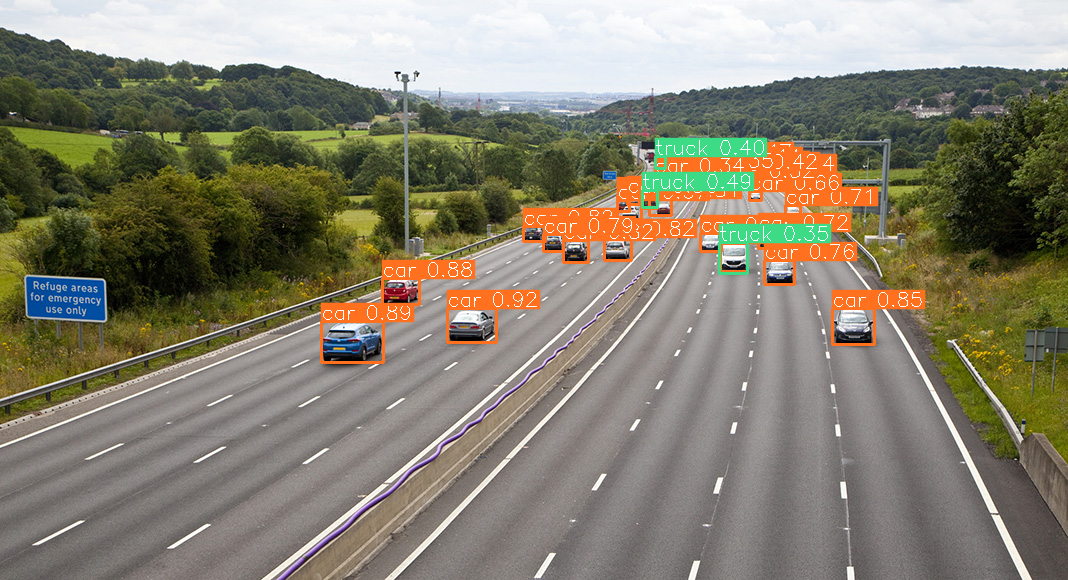

In [153]:
result.export_visuals(export_dir="demo_data/")

display_image("demo_data/prediction_visual.png")

In [28]:
object_prediction_list = result.object_prediction_list

In [29]:
object_prediction_list[0]

ObjectPrediction<
    bbox: BoundingBox: <(447.5575294494629, 308.2526397705078, 496.90771484375, 342.8026428222656), w: 49.35018539428711, h: 34.55000305175781>,
    mask: None,
    score: PredictionScore: <value: 0.9154349565505981>,
    category: Category: <id: 2, name: car>>

Есть возможность конвертации в разные форматы: 

In [30]:
coco_dict = result.to_coco_annotations()
# result.to_imantics_annotations() # Нужно иметь соответствуюзие модули
# result.to_fiftyone_detections()

In [126]:
# Тут можно поиграться и посмотреть как будет выглядеть нарезка с разными параметрами
def slice_and_show(image_path,
                   slice_height=256, slice_width=256,
                   overlap_height_ratio=0.2, overlap_width_ratio=0.2,
                   max_rows=3, max_cols=5):

    sliced = slice_image(
        image=image_path,
        slice_height=slice_height,
        slice_width=slice_width,
        overlap_height_ratio=overlap_height_ratio,
        overlap_width_ratio=overlap_width_ratio
    )

    _, axes = plt.subplots(nrows=max_rows, ncols=max_cols,
                           figsize=(max_cols * 3, max_rows * 3))
    for idx, image in enumerate(sliced.images):
        row = idx // max_cols
        col = idx % max_cols
        axes[row, col].axis("off")
        axes[row, col].imshow(image, cmap="gray")
    plt.subplots_adjust(wspace=.05, hspace=.05)
    plt.show()

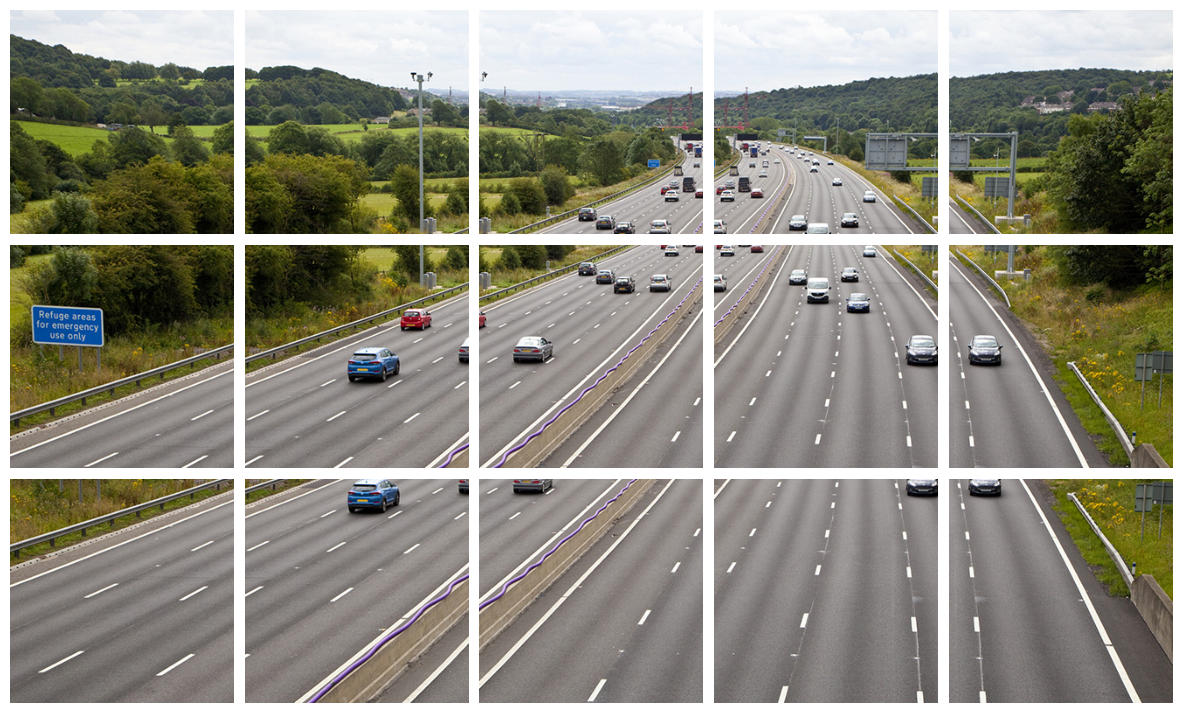

In [127]:
slice_and_show("demo_data/small-vehicles1.jpeg",
               slice_height=256, slice_width=256,
               overlap_height_ratio=0.2, overlap_width_ratio=0.2)

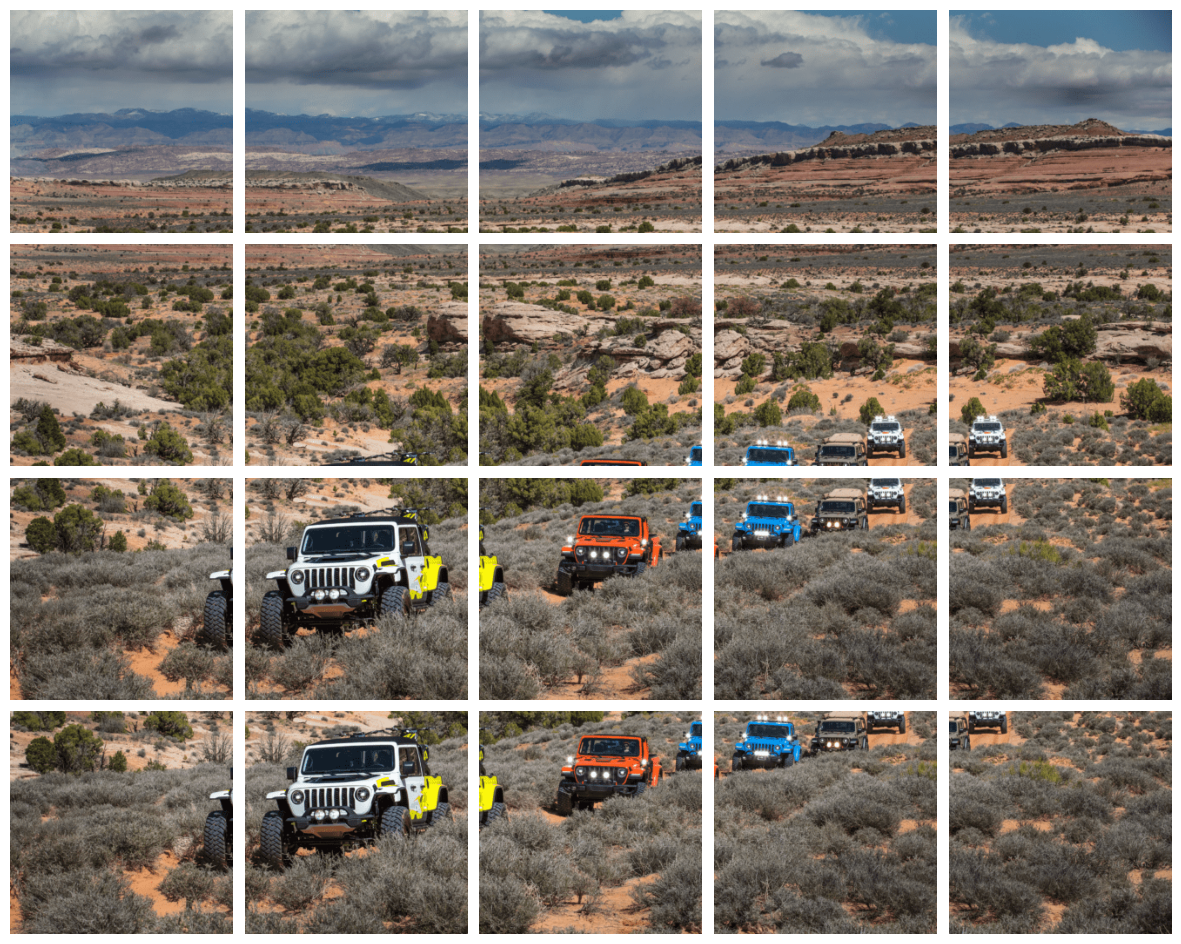

In [130]:
slice_and_show("demo_data/terrain2.png",
               slice_height=256, slice_width=256,
               overlap_height_ratio=0.2, overlap_width_ratio=0.2,
               max_rows=4, max_cols=5)

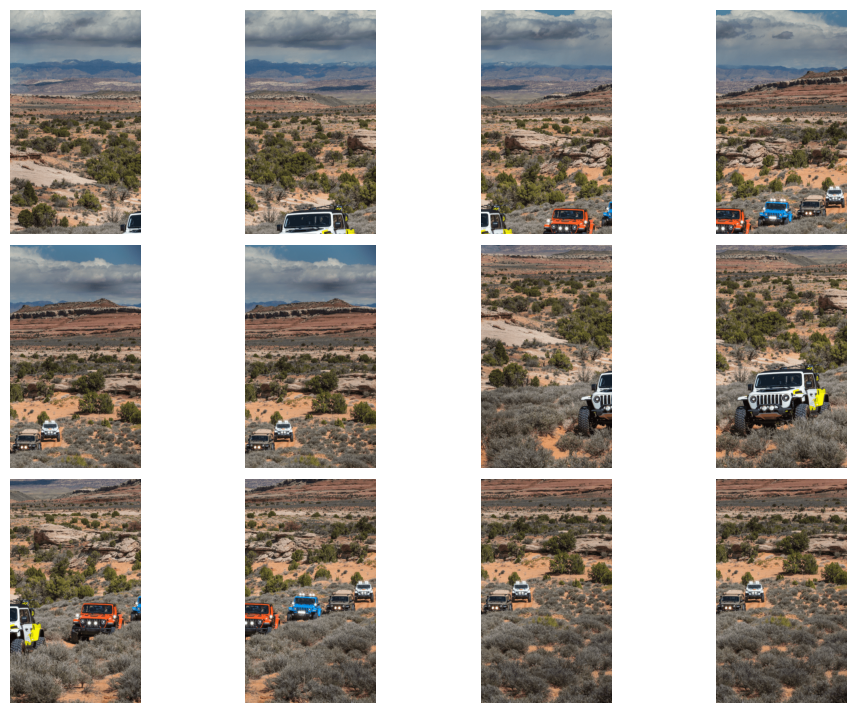

In [135]:
slice_and_show("demo_data/terrain2.png",
               slice_height=512, slice_width=300,
               overlap_height_ratio=0.4, overlap_width_ratio=0.4,
               max_rows=3, max_cols=4)